# **Custom Datasets**





### **1. Imports**

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.3.1+cpu


Setup device-agnostic code

In [2]:
device = "cude" if torch.cuda.is_available() else "cpu"
device

'cpu'

### **2. Get Data**

In [3]:
import requests
import zipfile
from pathlib import Path

# Step 1: Set up the path
url = "https://github.com/mohd-faizy/PyTorch-Essentials/raw/main/_datasets/pizza_steak_sushi.zip"
image_path = Path("data/pizza_steak_sushi")
image_path.mkdir(parents=True, exist_ok=True)
zip_path = image_path.parent / "pizza_steak_sushi.zip"

# Step 2: Download the zip file containing the data
zip_path.write_bytes(requests.get(url).content)

# Step 3: Unzip the downloaded file into the image directory
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(image_path)

### **3.Data Preparation and Data Exploration**

In [4]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### **4. Visualizing the Data**

Random Image path: data\pizza_steak_sushi\train\pizza\2382016.jpg
Image class: pizza
height x width: 512 x 512


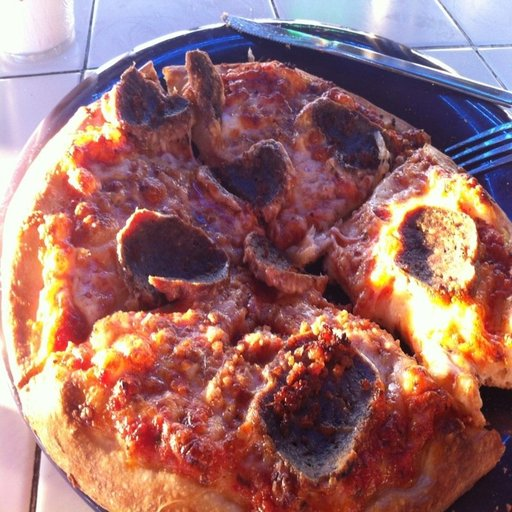

In [7]:
import random
from PIL import Image # Python Imaging Library

## set seed
# random.seed(42)

# 1. get all images path
# Use glob to find all .jpg images in subdirectories (two levels deep)
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
# Randomly select one image path from the list of all image paths
random_image_path = random.choice(image_path_list)

# 3. Get image class from the path name
# The image class in the name of the directory where the image is stored
image_class = random_image_path.parent.stem

# 4. Open image
# Open the image using Pillow's Image class
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"height x width: {img.height} x {img.width}")
img

### **5. `Image To Array`** **HWC**

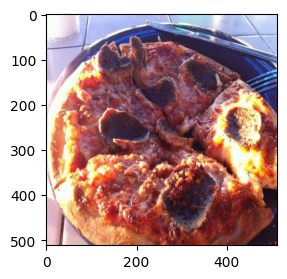

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image to array
img_array = np.array(img)

# plot image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_array);

In [9]:
print(f"{img_array.shape} -> height, width, color channels")
print(f"{img_array.ndim}")

(512, 512, 3) -> height, width, color channels
3


In [10]:
img_array

array([[[249, 254, 247],
        [249, 254, 247],
        [249, 254, 247],
        ...,
        [202, 217, 250],
        [203, 218, 251],
        [208, 223, 255]],

       [[249, 254, 247],
        [249, 254, 247],
        [249, 254, 247],
        ...,
        [205, 220, 253],
        [205, 220, 253],
        [207, 222, 255]],

       [[249, 254, 247],
        [249, 254, 247],
        [249, 254, 247],
        ...,
        [207, 222, 255],
        [205, 220, 253],
        [204, 219, 252]],

       ...,

       [[241, 201, 201],
        [241, 201, 201],
        [242, 202, 202],
        ...,
        [115,  65,  66],
        [100,  44,  43],
        [ 75,  17,  15]],

       [[240, 200, 198],
        [241, 201, 199],
        [241, 201, 199],
        ...,
        [ 95,  49,  51],
        [ 75,  25,  24],
        [ 64,  13,  10]],

       [[239, 199, 197],
        [240, 200, 198],
        [241, 201, 199],
        ...,
        [ 81,  37,  38],
        [ 61,  13,  13],
        [ 64,  14,  13]]

### **6. Transforming data** (`Image To Tensor`) **CHW**

- Numerical representation of our images

- Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

- Transforms help you get your images ready to be used with a model/perform data augmentation - [**PyTorch Transform**](https://pytorch.org/vision/stable/transforms.html)

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

```python
from torchvision.transforms import ToTensor
```

In [12]:
data_transform = transforms.Compose([         # Write a transform for image
    transforms.Resize(size=(64, 64)),         # Resize our images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),   # Flip the images randomly on the horizontal ~ prob 50% i.e img transfrom 50% of time
    transforms.ToTensor()                     # Turn the image into a torch.Tensor
])

In [13]:
data_transform(img).shape, data_transform(img).dtype # CHW

(torch.Size([3, 64, 64]), torch.float32)

**Note:** `PyTorch` transform our image to color channel first `[3, 64, 64]`, while `Matplotlib` prefer color channel last `[64, 64, 3]`.




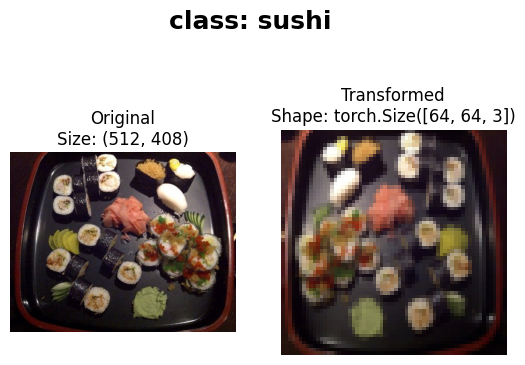

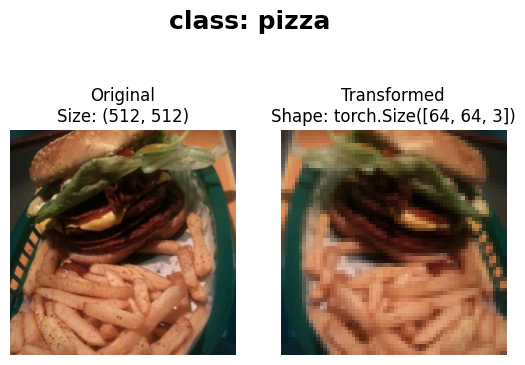

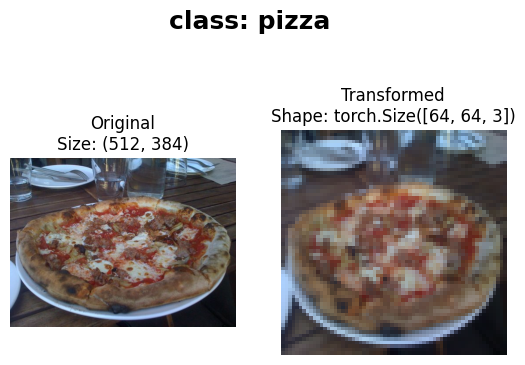

In [14]:
def plot_transformed_images(image_path:list, transform, n=3, seed=None):
    """
    This function takes a list of image paths, applies the specified transformation,
    and plots the original and transformed versions side by side. The seed parameter
    allows for reproducible random sampling. You can use this function by passing
    your own image_path_list and data_transform.

    Args:
        `image_paths` (list): A list of image file paths.
        `transform`: An image transformation function (e.g., rotation, scaling, etc.).
        `n` (int, optional): The number of images to select (default is 3).
        `seed` (int, optional): Random seed for reproducibility (default is None).

    Returns:
        None (plots the images)

    Example usage:
        plot_transformed_images(image_paths=image_path_list,
                                transform=data_transform,
                                n=3,
                                seed=None)
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"class: {image_path.parent.stem}", fontsize=18, weight='bold')


plot_transformed_images(image_path=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

### **7. Loading Dataset ~ `Option-1`**

#### Loading Image Data using **Pytorch** `ImageFolder`

**Note:** The `ImageFolder` class in PyTorch expects the images to be arranged in a specific folder structure by default. Here’s how it should be organized:


```
my_dataset/
    ├──train/
    │   ├── cats/
    │   │   ├── cat1.jpg
    │   │   ├── cat2.jpg
    │   │   └── ...
    │   ├── dogs/
    │   │   ├── dog1.jpg
    │   │   ├── dog2.jpg
    │   │   └── ...
    │   └── birds/
    │        ├── bird1.jpg
    │        ├── bird2.jpg
    │        └── ...
    └──test/    
        ├── cats/
        │   ├── cat1.jpg
        │   ├── cat2.jpg
        │   └── ...
        ├── dogs/
        │   ├── dog1.jpg
        │   ├── dog2.jpg
        │   └── ...
        └── birds/
            ├── bird1.jpg
            ├── bird2.jpg
            └── ...
```

#### 7.1 `ImageFolder`

```python
from torchvision.datasets import ImageFolder
```

In [15]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [16]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                         transform=data_transform,
                         target_transform=None)

test_data = ImageFolder(root=test_dir,
                        transform=data_transform,
                        target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
len(train_data), len(test_data)

(225, 75)

In [18]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

print(class_names)
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [19]:
print(train_data.samples[0])      # image, label
print(train_data.samples[0][0])   # image
print(train_data.samples[0][1])   # Label

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)
data\pizza_steak_sushi\train\pizza\1008844.jpg
0


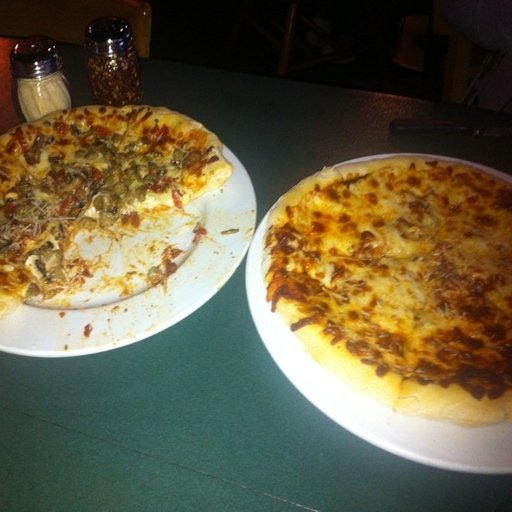

In [20]:
Image.open(train_data.samples[0][0]) # sample image

In [21]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"image label: {label}")
print(f"label datatype: {type(label)}")

Image Tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image Permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

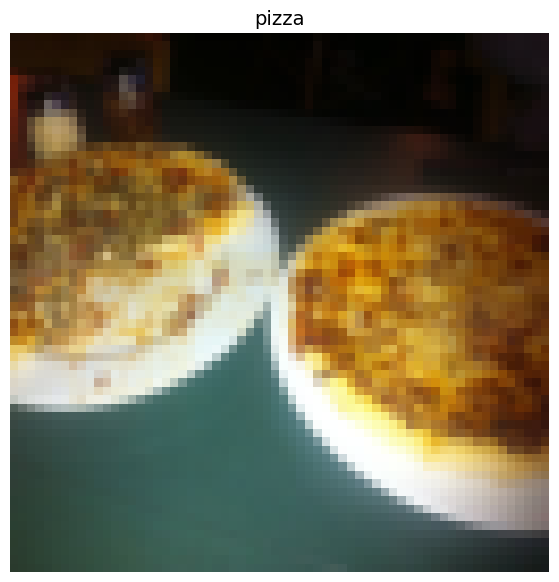

In [22]:
# Plot: Matplotlib ~ HWC -> color channel last
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image Permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

#### 7.2 `DataLoader`

```python
from torch.utils.data import DataLoader
```

A `DataLoader` help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

1. **Data Preparation**: The DataLoader helps you standardize these processes, making your code more readable and maintainable.

2. **Batching**: It allows you to define how many training or testing samples to use in a single iteration. Working with batches of data makes training and testing more manageable.

3. **Shuffling**: DataLoader can shuffle data for you as it loads batches. This increases dataset representativeness and prevents accidental `skewness`.

4. **Multi-processing**: PyTorch optimizes running multiple processes at once, utilizing modern `CPUs` and `GPUs`. DataLoader lets you define how many workers should go at once.

5. **Merging Datasets**: Optionally, you can merge multiple datasets together using DataLoader.

6. **Direct Loading on CUDA**: If you’re using a GPU, DataLoader can load data directly onto CUDA tensors.

In [23]:
# Checking the number of avalible core
import os
os.cpu_count()

8

In [24]:
# Turn the train test datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=2, # available cores for parallel data loading
                              shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=2,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f9e4098b50>,
 <torch.utils.data.dataloader.DataLoader at 0x1f9e406cdd0>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, we can change the batch size
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### **8. Loading Dataset ~ `Option-2`**

#### **Loading Image Data with a `Custom` Dataset Function**

Desired functionality for custom function:
- load images from file.
- get `class names` from the Dataset.
- get `classes as dictionary` from the Dataset.

**Pros**
- Can create the `dataset` out of almost anything.
- For complex datasets, custom classes can allow for optimizations like caching or lazy loading mechanisms, which might not be feasible with simpler approaches.

**Cons**
- Custom code can be prone to errors.
- Maintenance Overhead: As your dataset or data loading requirements change, you might need to modify the custom class to accommodate those changes

In [27]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### **8.1 Creating a helper function to get class names**

- Uses `os.scandir()` to traverse a target directory (ideally in standard image classification format).
- Extracts `class` names from the directory structure.
- Raises an `error` if no class names are found (indicating potential directory structure issues).
- Creates a dictionary and a list containing the class names.
- Returns the dictionary and list of class names.

---

```python
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Step 1: Scan the target directory
entries = os.scandir(target_dir)

# Step 2: Iterate through the entries and print their details
for entry in entries:
    print(f"Name: {entry.name}, Path: {entry.path}, Is File: {entry.is_file()}, Is Dir: {entry.is_dir()}")
```

```
Target directory: data\pizza_steak_sushi\train
Name: pizza, Path: data\pizza_steak_sushi\train\pizza, Is File: False, Is Dir: True
Name: steak, Path: data\pizza_steak_sushi\train\steak, Is File: False, Is Dir: True
Name: sushi, Path: data\pizza_steak_sushi\train\sushi, Is File: False, Is Dir: True
```

---

```python
# Scans the directory specified by target_dir and returns an iterator of os.DirEntry objects.
entries = os.scandir(target_dir)
# Converts the iterator into a list of os.DirEntry objects.
entry_names = [entry.name for entry in entries]
# Sorts the list of names in alphabetical order.
sorted_entry_names = sorted(entry_names)
# Stores the sorted list of entry names.
sorted_entry_names
```

```
['pizza', 'steak', 'sushi']
```
---

In [29]:
target_dir = train_dir
print(f"Target directory: {target_dir}")

print(list(os.scandir(target_dir)))

class_name = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_name

Target directory: data\pizza_steak_sushi\train
[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]


['pizza', 'steak', 'sushi']

In [30]:
# import os
# from typing import List, Dict, Tuple

# def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
#     # 1. Get the class names by scanning the target directory 
#     classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
#     # 2. Raise an error if class names could not be found
#     if not classes:
#         raise FileNotFoundError(f"classes not found in {directory}")
#     # 3. Create a dict of index labels(as computer prefer number over str labels)
#     class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
#     return classes, class_to_idx

# # Example usage
# if __name__ == "__main__":
#     try:
#         classes, class_indices = find_classes(train_dir)
#         print("Classes:", classes)
#         print("Class Indices:", class_indices)
#     except FileNotFoundError as e:
#         print(e)

In [ ]:
# find_classes(train_dir)

#### **8.2 Create a coustom `Dataset` to replicate `ImageFolder`**

In [32]:
from typing import List, Dict, Tuple
from pathlib import Path
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImageFolderCustom(Dataset):
    # Create  standalone function[find_classes] that can be used by calling `ImageFolderCustom.find_classes(directory)` without creating an instance.
    # Note: These static methods don't need an instance of the class (self). They can be called directly on the class itself.
    @staticmethod
    def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
        """
        Finds classes in a directory and creates a mapping of class names to integer labels.

        Args:
            directory (str): Path to the directory containing class subdirectories.

        Returns:
            Tuple[List[str], Dict[str, int]]: Tuple containing a list of classes and a mapping of class names to integer labels.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Classes not found in {directory}")
        class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
        return classes, class_to_idx

    def __init__(self, targ_dir: str, transform: transforms.Compose = None):
        """
        Custom dataset class for loading images from a directory.

        Args:
            targ_dir (str): Path to the directory containing image files.
            transform (transforms.Compose, optional): A torchvision transform to apply to the image data.
        """
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = self.find_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:
        """
        Opens an image from a given index and returns it.

        Args:
            index (int): Index of the image in the dataset.

        Returns:
            Image.Image: The loaded image.
        """
        try:
            image_path = self.paths[index]
            return Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image at index {index}: {e}")
            raise

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns one sample of data given an index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: Tuple containing the transformed image and its label.
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            img = self.transform(img)

        return img, class_idx

# Example usage
data_transform = transforms.Compose([         # Write a transform for image
    transforms.Resize(size=(64, 64)),         # Resize our images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),   # Flip the images randomly on the horizontal ~ prob 50% i.e img transfrom 50% of time
    transforms.ToTensor()                     # Turn the image into a torch.Tensor
])

# Create an instance of the custom dataset class
dataset = ImageFolderCustom(targ_dir=train_dir, transform=data_transform)


In [34]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
                                    transforms.Resize(size=(64, 64)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor() 
])

test_transforms = transforms.Compose([
                                    transforms.Resize(size=(64, 64)),
                                    transforms.ToTensor()
])

In [35]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [36]:
len(train_data), len(train_data_custom)

(225, 225)

In [37]:
len(test_data), len(test_data_custom)

(75, 75)

In [42]:
train_data_custom.find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

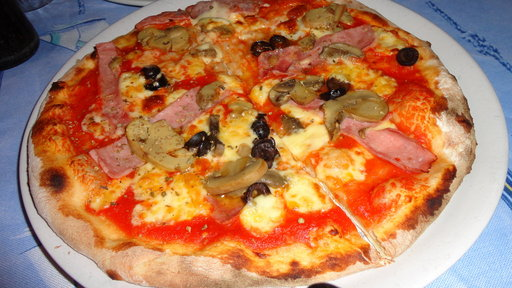

In [45]:
train_data_custom.load_image(3)

In [38]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [40]:
class MathOperations:
    @staticmethod
    def add(x, y):
        return x + y
    
    @staticmethod
    def multiply(x, y):
        return x * y

# Using static methods
result_add = MathOperations.add(5, 3)
print("Addition result:", result_add)  # Output: Addition result: 8

result_multiply = MathOperations.multiply(5, 3)
print("Multiplication result:", result_multiply)  # Output: Multiplication result: 15

Addition result: 8
Multiplication result: 15


# **_One-code**


In [ ]:
# import os
# import requests
# import zipfile
# from pathlib import Path

# import torch
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# from torchvision.datasets import ImageFolder

# # Print torch version
# print(torch.__version__)

# # Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # Step 1: Set up the path
# url = "https://github.com/mohd-faizy/PyTorch-Essentials/raw/main/_datasets/pizza_steak_sushi.zip"
# image_path = Path("data/pizza_steak_sushi")
# image_path.mkdir(parents=True, exist_ok=True)
# zip_path = image_path.parent / "pizza_steak_sushi.zip"

# # Step 2: Download the zip file containing the data
# zip_path.write_bytes(requests.get(url).content)

# # Step 3: Unzip the downloaded file into the image directory
# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(image_path)

# # Setup train and test paths
# train_dir = image_path / "train"
# test_dir = image_path / "test"

# # data Transform
# data_transform = transforms.Compose([         
#     transforms.Resize(size=(64, 64)),         
#     transforms.RandomHorizontalFlip(p=0.5),   
#     transforms.ToTensor()                     
# ])

# # Create train and test `datasets`
# train_data = ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
# test_data = ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

# class_names = train_data.classes
# class_dict = train_data.class_to_idx

# # Turn the train and test datasets into `DataLoaders`
# train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=os.cpu_count(), shuffle=False)
# test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=os.cpu_count(), shuffle=False)


# img, label = next(iter(train_dataloader))
# print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")